In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

#### **Transformacja między współrzędnymi świata a kamery**

W kontekście szacowania pozycji kamery (**camera pose estimation**), mamy dwa układy współrzędnych:
- **Współrzędne świata** (układ globalny, czyli związany z obiektami w przestrzeni).
- **Współrzędne kamery** (układ lokalny, czyli związany z kamerą).

Standardowa formuła, która przekształca punkt z układu współrzędnych świata na układ współrzędnych kamery, to:

$$ P_c = R \cdot (P_o - T) $$

Gdzie:
- $P_c$: Punkt we współrzędnych kamery (widziany z kamery).
- $P_o$: Ten sam punkt, ale w układzie współrzędnych świata.
- $R$: Macierz rotacji, która przekształca punkty ze współrzędnych świata do współrzędnych kamery (czyli opisuje, jak kamera jest obrócona względem świata).
- $T$: Wektor translacji, który opisuje pozycję kamery w układzie współrzędnych świata.

---

#### **Obliczanie pozycji kamery**

Aby znaleźć pozycję kamery w układzie współrzędnych świata, musimy wziąć pod uwagę, że pozycja kamery w jej własnym układzie to $P_c = 0$, ponieważ kamera "widzi siebie" w punkcie $(0, 0, 0)$.

Podstawiając $P_c = 0$ do równania, otrzymujemy:

$$ 0 = R \cdot (P_o - T) $$

Rozwiązując to równanie względem $P_o$, dostajemy:

$$ P_o = T $$

Oznacza to, że **pozycja kamery** we współrzędnych świata to po prostu wektor translacji $T$.

---

#### **Zależność od metody OpenCV `solvePnP`**

Kiedy korzystasz z funkcji `cv.solvePnP`, otrzymujesz:
- **$R$**: Macierz rotacji (orientacja kamery względem układu świata).
- **$t$**: Wektor translacji, który opisuje **pozycję początku układu współrzędnych świata względem kamery**.

Warto jednak zwrócić uwagę, że wektor $t$ uzyskany z `solvePnP` mówi nam **gdzie znajduje się początek układu świata w układzie kamery**. Dlatego, aby znaleźć faktyczną pozycję kamery w układzie współrzędnych świata, musimy tę transformację odwrócić.

---

#### **Odwrócenie transformacji (macierz odwrotna rotacji i wektor translacji)**

Aby przekształcić translację uzyskaną z `solvePnP` na pozycję kamery we współrzędnych świata, musimy:
1. **Odwrócić rotację** – używamy do tego transpozycji macierzy $R^T$ (bo macierze rotacji są ortonormalne, więc ich odwrotność to transpozycja).
2. **Odwrócić wektor translacji** – ponieważ wektor $t$ mówi nam, gdzie jest świat względem kamery, a nie gdzie jest kamera względem świata, dodajemy znak minus.

Finalna formuła to:

$$ P_o = -R^T \cdot t $$

Gdzie:
- $P_o$: Pozycja kamery we współrzędnych świata.
- $R^T$: Transpozycja macierzy rotacji, która przekształca z układu kamery do układu świata.
- $t$: Wektor translacji uzyskany z `solvePnP`.

---

#### **Podsumowanie**

- **$P_o = T$**: Jeśli $T$ to wektor translacji opisujący pozycję kamery względem świata, to pozycja kamery w świecie to $T$.
- **$P_o = -R^T \cdot t$**: Jeśli $t$ to wektor translacji uzyskany z `solvePnP`, który opisuje pozycję świata względem kamery, musimy odwrócić tę relację, używając transpozycji rotacji i zmieniając znak, aby otrzymać faktyczną pozycję kamery w układzie świata.

Dzięki temu, korzystając z wyników funkcji OpenCV `solvePnP`, możemy dokładnie określić, gdzie znajduje się kamera w przestrzeni 3D, co jest kluczowe przy takich zadaniach jak śledzenie pozycji kamery lub rekonstrukcja sceny.


### **1. Estimate Camera Pose with ArUco**

In [2]:
MARKER_SIZE = 180  # Marker size in mm.
DICTIONARY = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_4X4_50)

# SOLVEPNP_IPPE_SQUARE Special case suitable for marker pose estimation.
# Number of input points must be 4. Object points must be defined in the following order:
# point 0: [-squareLength / 2, squareLength / 2, 0]
# point 1: [ squareLength / 2, squareLength / 2, 0]
# point 2: [ squareLength / 2, -squareLength / 2, 0]
# point 3: [-squareLength / 2, -squareLength / 2, 0]
MARKER3D = np.array(
    [
        [-MARKER_SIZE / 2, MARKER_SIZE / 2, 0],
        [MARKER_SIZE / 2, MARKER_SIZE / 2, 0],
        [MARKER_SIZE / 2, -MARKER_SIZE / 2, 0],
        [-MARKER_SIZE / 2, -MARKER_SIZE / 2, 0],
    ],
    dtype=np.float32,
)

parameters = cv.aruco.DetectorParameters()
detector = cv.aruco.ArucoDetector(DICTIONARY, parameters)

camera_matrix = np.loadtxt("./assets/huawei_camera_matrix.txt")
dist_coeffs = np.loadtxt("./assets/huawei_dist_coeffs.txt")

In [3]:
# Estimate camera pose using the detected markers.
def estimate_pose(markers_corners, camera_matrix, dist_coeffs):
    rvecs = list()
    tvecs = list()

    for marker_corners in markers_corners:
        _, rvec, tvec = cv.solvePnP(
            MARKER3D,
            marker_corners,
            camera_matrix,
            dist_coeffs,
            useExtrinsicGuess=False,
            flags=cv.SOLVEPNP_IPPE_SQUARE,
        )
        rvecs.append(rvec)
        tvecs.append(tvec)

    return rvecs, tvecs


def draw_axis(img, rvecs, tvecs, camera_matrix, dist_coeffs):
    for rvec, tvec in zip(rvecs, tvecs):
        cv.drawFrameAxes(img, camera_matrix, dist_coeffs, rvec, tvec, MARKER_SIZE)

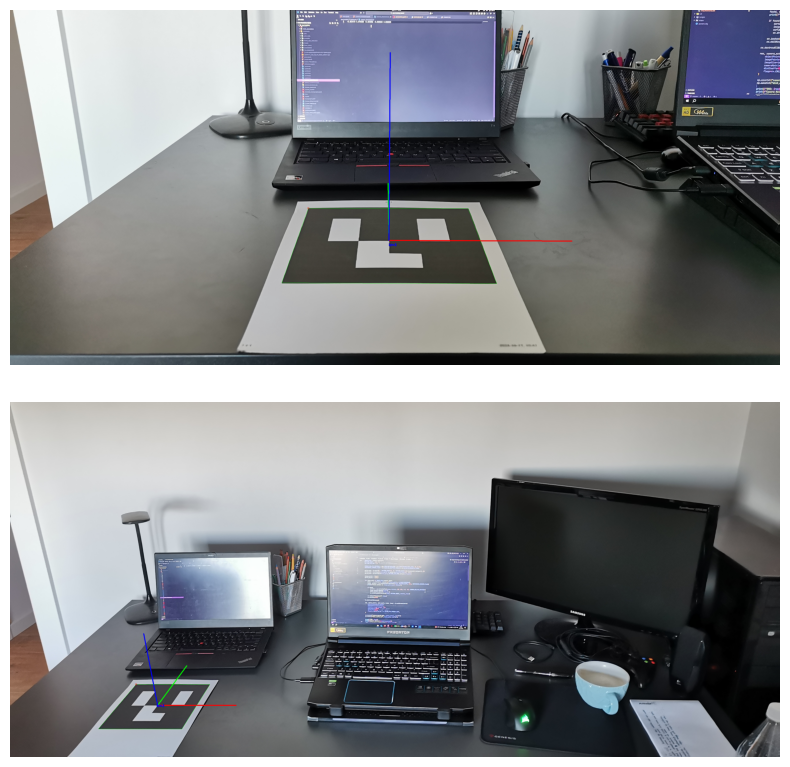

In [4]:
image1 = cv.imread("./assets/aruco/view1.jpg")
image2 = cv.imread("./assets/aruco/view3.jpg")

corners1, ids1, rejected1 = detector.detectMarkers(cv.cvtColor(image1, cv.COLOR_BGR2GRAY))
corners2, ids2, rejected2 = detector.detectMarkers(cv.cvtColor(image2, cv.COLOR_BGR2GRAY))

# Check that all IDs are unique.
assert len(set(ids1.flatten())) == len(ids1.flatten())
assert len(set(ids2.flatten())) == len(ids2.flatten())

rvecs1, tvecs1 = estimate_pose(corners1, camera_matrix, dist_coeffs)
rvecs2, tvecs2 = estimate_pose(corners2, camera_matrix, dist_coeffs)

draw_axis(image1, rvecs1, tvecs1, camera_matrix, dist_coeffs)
draw_axis(image2, rvecs2, tvecs2, camera_matrix, dist_coeffs)

cv.aruco.drawDetectedMarkers(image1, corners1, ids1)
cv.aruco.drawDetectedMarkers(image2, corners2, ids2)

# Axis-color correspondences are X: red, Y: green, Z: blue
plt.figure(figsize=(8, 8), tight_layout=True)
plt.subplot(2, 1, 1)
plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [5]:
Rvecs = list()
tvecs = list()

# Find corresponding markers, and calculate Camera 2 pose in relation to Camera 1.
for n, id1 in enumerate(ids1):
    for m, id2 in enumerate(ids2):
        if id1 == id2:
            print(f"Matched: {n} -> {m}")

            rvec1, rvec2 = rvecs1[n], rvecs2[m]
            tvec1, tvec2 = tvecs1[n], tvecs2[m]

            R1 = cv.Rodrigues(rvec1)[0]
            R2 = cv.Rodrigues(rvec2)[0]

            # Calculate Camera 2 pose in relation to Camera 1.
            R = R2 @ np.linalg.inv(R1)  # Or R1.T but R1^-1 is more general.
            t = tvec2 - R @ tvec1

            Rvecs.append(R)
            tvecs.append(t)

# All Rvecs and tvecs should be roughly the same for corresponding markers
# so we can take median and get more robust result.
R = np.median(Rvecs, axis=0)
t = np.median(tvecs, axis=0)

print("Camera 2 pose in relation to Camera 1:")
print(f"R:\n {R}")
print(f"t:\n {t}")

Matched: 0 -> 0
Camera 2 pose in relation to Camera 1:
R:
 [[ 0.99748127  0.01266957  0.06978971]
 [-0.00904208  0.99860354 -0.05205013]
 [-0.07035171  0.05128799  0.99620288]]
t:
 [[-575.18118913]
 [ 260.36094017]
 [ 793.55448595]]


### **2. Camera Placements**

In [6]:
# https://stackoverflow.com/questions/8130823/set-matplotlib-3d-plot-aspect-ratio
def axis_equal_3d(ax):
    extents = np.array([getattr(ax, "get_{}lim".format(dim))() for dim in "xyz"])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    for ctr, dim in zip(centers, "xyz"):
        getattr(ax, "set_{}lim".format(dim))(ctr - r, ctr + r)


def plot_camera_position(ax, R, t, camera_size=1, arrow_len=1, arrow_ratio=0.1):
    # Maplotlib coordinate system is different from typical camera coordinate system.
    # In camera coordinate system X is right, Y is down, and Z is forward.
    swap_yz = lambda v: v[[0, 2, 1]]
    inverse_y = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])

    R = R @ inverse_y

    center = swap_yz(np.dot(-np.linalg.inv(R), t).flatten())
    vx = swap_yz(np.linalg.inv(R) @ np.array([1, 0, 0]))
    vy = swap_yz(np.linalg.inv(R) @ np.array([0, -1, 0]))  # Inverted Y axis.
    vz = swap_yz(np.linalg.inv(R) @ np.array([0, 0, 1]))

    ax.quiver(*center, *vx, color="r", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.quiver(*center, *vy, color="g", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.quiver(*center, *vz, color="b", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.scatter(*center, color="orange", s=camera_size)

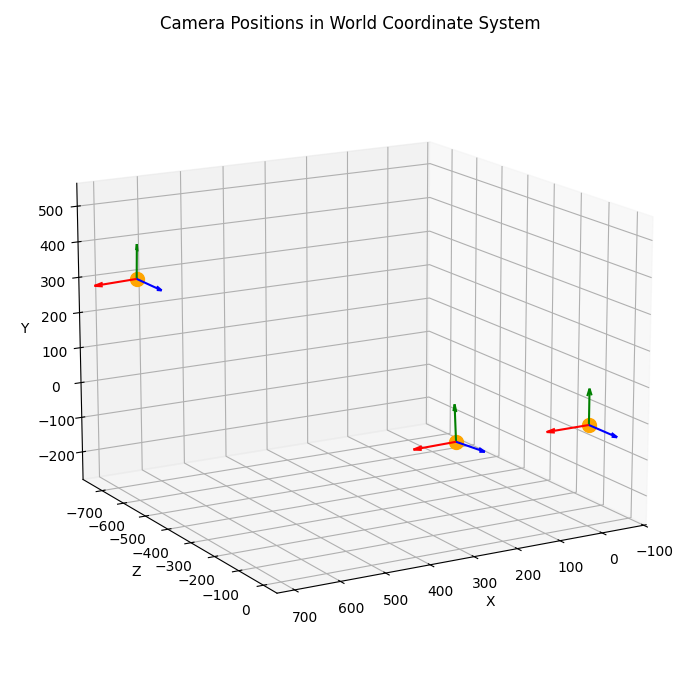

In [7]:
%matplotlib widget

# Camera 1 is our origin.
R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = np.array(
    [
        [9.99046983e-01, -7.14866306e-04, 4.36418985e-02],
        [-1.94642140e-03, 9.98141538e-01, 6.09071621e-02],
        [-4.36043322e-02, -6.09340620e-02, 9.97188900e-01],
    ]
)
t2 = np.array([[-274.74815007], [-6.1177553], [65.67975754]])

R3 = np.array(
    [
        [0.99748127, 0.01266957, 0.06978971],
        [-0.00904208, 0.99860354, -0.05205013],
        [-0.07035171, 0.05128799, 0.99620288],
    ]
)
t3 = np.array([[-575.18118913], [260.36094017], [793.55448595]])

plt.close()
plt.figure(figsize=(7, 7), tight_layout=True)
ax = plt.axes(projection="3d")
ax.view_init(elev=15, azim=60, roll=0)  # type: ignore
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")  # type: ignore
ax.set_title("Camera Positions in World Coordinate System")
plot_camera_position(ax, R1, t1, 100, 100, 0.2)
plot_camera_position(ax, R2, t2, 100, 100, 0.2)
plot_camera_position(ax, R3, t3, 100, 100, 0.2)
axis_equal_3d(ax)
plt.show()